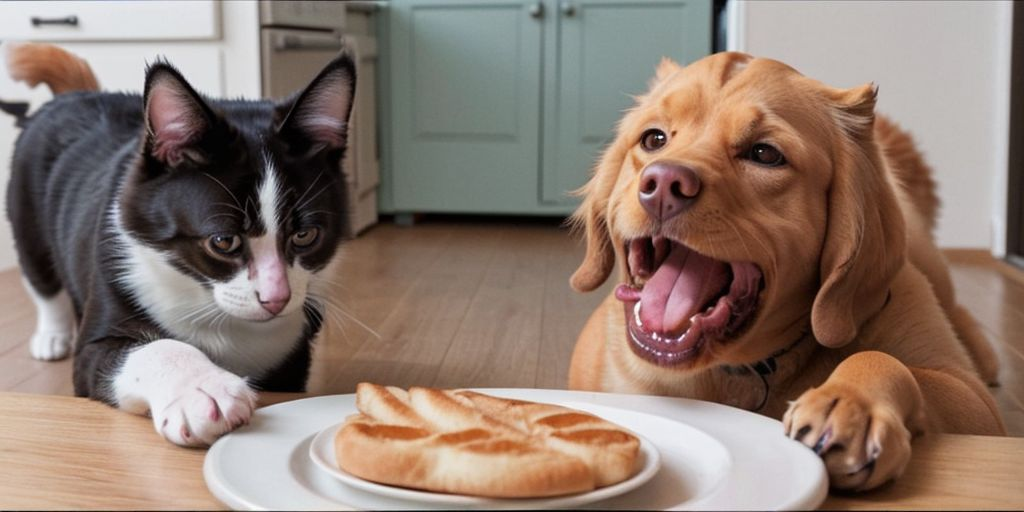

# Project Overview
This notebook made for the to DataTalksClub Machine Learning Zoomcamp Capstone Project 1 and is made by Lokman Efe and is about Dog or Cat Classification.

My Kaggle Profile: https://www.kaggle.com/lokmanefe

My GitHub Profile: https://github.com/lokicik

My LinkedIn Profile: https://www.linkedin.com/in/lokmanefe/

Feel free to reach out! ✌


You should download the dataset and change the variables' paths in the scripts to dataset's path but I suggest you to run the scripts in Kaggle notebooks and don't download the data, it would be easier since you wouldn't have to download the data, which is over 100 mb's. I developed the project on Kaggle too, so you don't have to change the dataset paths in the scripts, you just have to add the data to your notebook if you work on Kaggle.

# Project Presentation
I would like to introduce my most comprehensive project to date! I have completed the project "Dog or Cat Classification (CNN) deployed with AWS Lambda" which I developed as the Capstone Project 1 of the Machine Learning Zoomcamp organized by DataTalksClub and presented by Alexey Grigorev. I had the opportunity to apply all the techniques I learned, and I gave my all to this project. I look forward to your feedback and hope for positive reviews!

## Description of the Problem
In the digital age, the sheer volume of images available on the internet poses a challenge 
for effective categorization. One prevalent domain is the classification of images 
into distinct categories, such as identifying whether an image contains a dog or a cat. 
This task is not only time-consuming but also prone to human error, making it a prime 
candidate for automation.

## Problem Solution
This project focuses on developing an image classification 
system capable of identifying images whether it's a dog or a cat.
Leveraging state-of-the-art deep learning techniques, a convolutional neural network (CNN) 
is trained to analyze and learn distinctive features present in dog and cat images.

## Dataset (https://www.kaggle.com/competitions/dogs-vs-cats/data)
The training archive contains 25,000 images of dogs and cats. 
Train an algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).



# Project Requirements (Evaluation Criteria)
* Problem description
* EDA
* Model training
* Exporting notebook to script
* Model deployment
* Reproducibility
* Dependency and environment management
* Containerization
* Cloud deployment

# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_42/1272549741.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Adding the data

In [2]:
import os
print(os.listdir("../input"))

import zipfile

with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

['dogs-vs-cats']


In [3]:
main_dir = "/kaggle/working/"
train_dir = "train"
path = os.path.join(main_dir,train_dir)

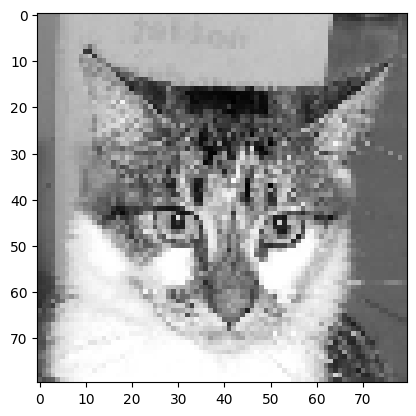

In [4]:
for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [5]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)

In [7]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)
X = X/255.0

# EDA (Exploratory Data Analysis)

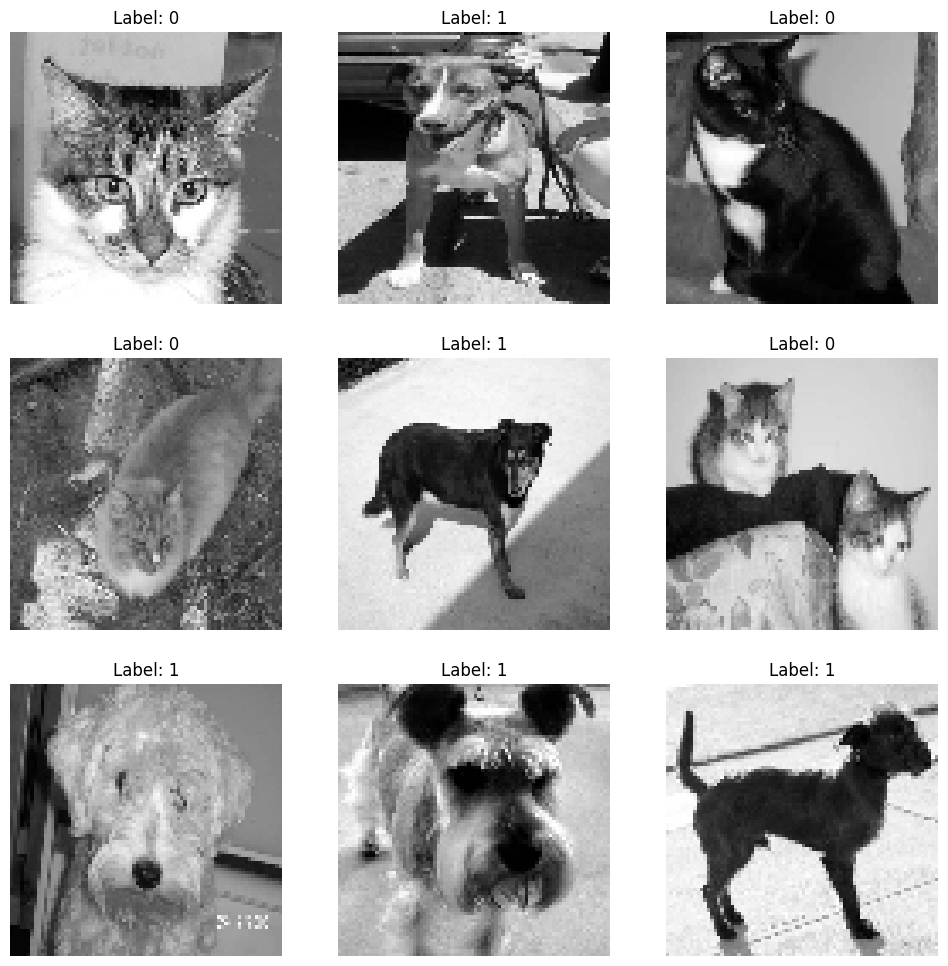

In [51]:
# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i].reshape(80, 80), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.show()

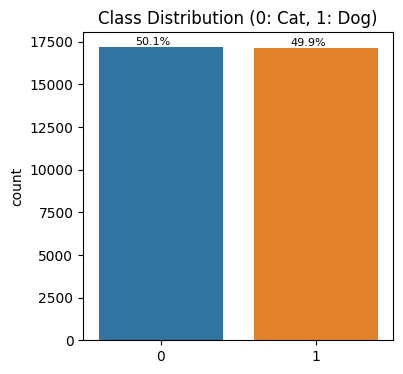

In [52]:
# Visualize class distribution with percentage values on top of the bars
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=y)
plt.title('Class Distribution (0: Cat, 1: Dog)')

# Add percentage values on top of the bars
total = len(y)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    d = p.get_x() + p.get_width() / 2 - 0.05
    z = p.get_height() + 0.1
    ax.text(d, z, percentage, ha='center', va='bottom', fontsize=8, color='black')

plt.show()

### Splitting the data for train and validation

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a base model

In [9]:
# Define the Deep Learning Model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and connect Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with a single neuron and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile the model with optimizer and loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Create augmented data generators
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [12]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [13]:
# Train the model with augmented data and early stopping
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
858/858 [==============================] - 33s 26ms/step - loss: 0.6638 - accuracy: 0.5966 - val_loss: 0.6109 - val_accuracy: 0.6688
Epoch 2/10
858/858 [==============================] - 22s 25ms/step - loss: 0.5947 - accuracy: 0.6888 - val_loss: 0.5494 - val_accuracy: 0.7269
Epoch 3/10
858/858 [==============================] - 22s 25ms/step - loss: 0.5443 - accuracy: 0.7296 - val_loss: 0.5184 - val_accuracy: 0.7442
Epoch 4/10
858/858 [==============================] - 22s 26ms/step - loss: 0.5140 - accuracy: 0.7563 - val_loss: 0.4801 - val_accuracy: 0.7754
Epoch 5/10
858/858 [==============================] - 22s 25ms/step - loss: 0.4953 - accuracy: 0.7664 - val_loss: 0.4629 - val_accuracy: 0.7814
Epoch 6/10
858/858 [==============================] - 22s 25ms/step - loss: 0.4691 - accuracy: 0.7823 - val_loss: 0.4499 - val_accuracy: 0.7891
Epoch 7/10
858/858 [==============================] - 22s 25ms/step - loss: 0.4597 - accuracy: 0.7855 - val_loss: 0.4452 - val_accuracy:

### Evaluate the performance

In [15]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

215/215 [==============================] - 1s 3ms/step - loss: 0.4497 - accuracy: 0.7862
Validation Loss: 0.44965749979019165, Validation Accuracy: 0.7861616611480713


The validation accuracy for the base model is: 0.78

In [16]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

1073/1073 [==============================] - 4s 4ms/step - loss: 0.4194 - accuracy: 0.8017
Train Loss: 0.41938233375549316, Train Accuracy: 0.801724910736084


# ##############################
## I am going to try to create a preprocess function for the prediction here

In [22]:
!wget "https://unsplash.com/photos/9vvEXgi95Tc/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzAyODU0NzM2fA&force=true" -O image.jpg

--2023-12-17 23:12:31--  https://unsplash.com/photos/9vvEXgi95Tc/download?ixid=M3wxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNzAyODU0NzM2fA&force=true
Resolving unsplash.com (unsplash.com)... 151.101.1.181, 151.101.65.181, 151.101.193.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.1.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://images.unsplash.com/photo-1598875706250-21faaf804361?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=nita-anggraeni-goenawan-9vvEXgi95Tc-unsplash.jpg [following]
--2023-12-17 23:12:31--  https://images.unsplash.com/photo-1598875706250-21faaf804361?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=nita-anggraeni-goenawan-9vvEXgi95Tc-unsplash.jpg
Resolving images.unsplash.com (images.unsplash.com)... 151.101.22.208, 2a04:4e42:5::720
Connecting to images.unsplash.com (images.unsplash.com)|151.101.22.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 602026 (588K) [image/jpeg]
Saving to: 'imag

In [55]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

def preprocess(X):
      if isinstance(X, np.ndarray):
        # Already a NumPy array, just normalize
        X = X/255.0
        return X
      else:
        # Convert PIL image to NumPy array
        X = np.array(X)
        # Assuming RGB image, convert to grayscale 
        X = X[:, :, 0]
        # Reshape and normalize
        X = np.array(X).reshape(-1,80, 80, 1)
        X = X/255.0
        return X

img = load_img('/kaggle/working/image.jpg', target_size=(80, 80))
U = preprocess(img)

preds = model.predict(U)

1/1 [==============================] - 0s 19ms/step


In [56]:
preds

array([[0.9742235]], dtype=float32)

Seems like the structure works, let's keep going.

# ########################

### Visualizations

Text(0.5, 1.0, 'Accuracy Curves')

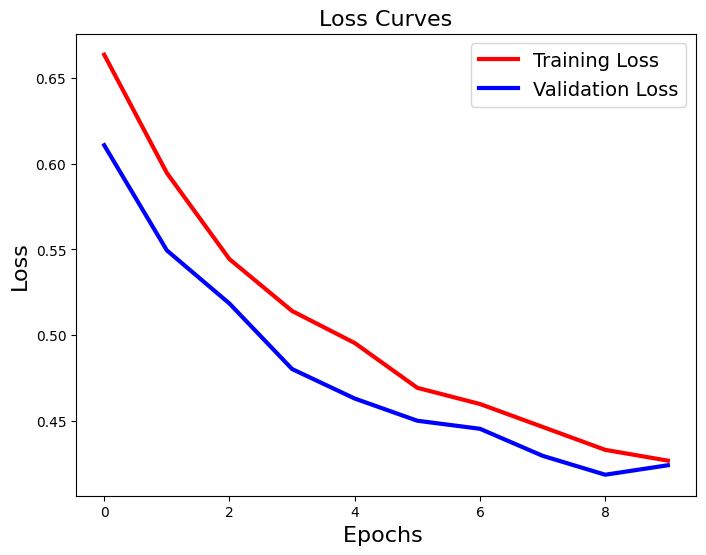

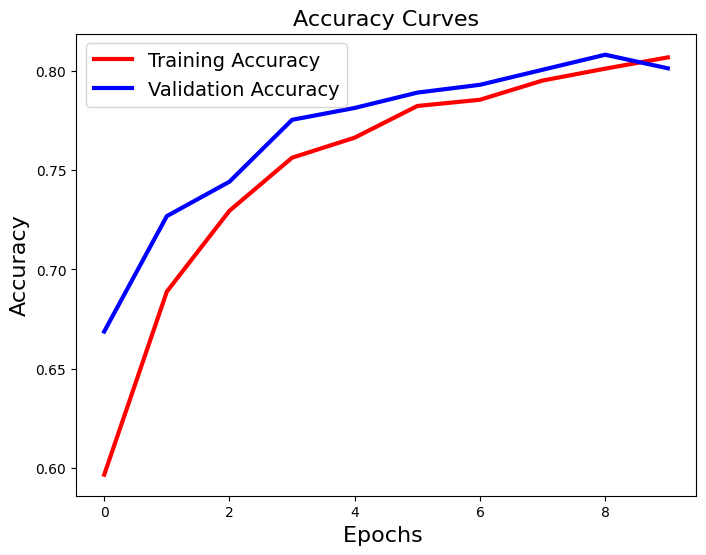

In [33]:
# Plot loss history
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


# Plot accuracy history
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Epoch 9 might be the ideal option here.

# Hyperparameter Optimization

In [34]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=128, max_value=256, step=64), (3, 3), input_shape=(80, 80, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=128, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense1_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(hp.Int('dense2_units', min_value=128, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), # More rates can be added here
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [36]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials as needed
    directory='keras_tuner_dir',
    project_name='cats_vs_dogs'
)

tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Trial 10 Complete [00h 04m 02s]
val_accuracy: 0.8253459334373474

Best val_accuracy So Far: 0.8298616409301758
Total elapsed time: 00h 43m 15s


In [38]:
# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]

In [61]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/cats_vs_dogs
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
conv1_units: 256
conv2_units: 192
dense1_units: 256
dense2_units: 192
learning_rate: 0.0001
Score: 0.8298616409301758

Trial 00 summary
Hyperparameters:
conv1_units: 128
conv2_units: 192
dense1_units: 192
dense2_units: 192
learning_rate: 0.0001
Score: 0.8268026113510132

Trial 03 summary
Hyperparameters:
conv1_units: 128
conv2_units: 128
dense1_units: 256
dense2_units: 192
learning_rate: 0.0001
Score: 0.8262199759483337

Trial 09 summary
Hyperparameters:
conv1_units: 128
conv2_units: 256
dense1_units: 128
dense2_units: 256
learning_rate: 0.0001
Score: 0.8253459334373474

Trial 01 summary
Hyperparameters:
conv1_units: 128
conv2_units: 128
dense1_units: 128
dense2_units: 128
learning_rate: 0.0001
Score: 0.8243262767791748

Trial 06 summary
Hyperparameters:
conv1_units: 192
conv2_units: 256
dense1_units: 128
dense2_units: 192
lea

### Evaluate the performance

In [39]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

215/215 [==============================] - 2s 9ms/step - loss: 0.3798 - accuracy: 0.8290
Validation Loss: 0.3797581195831299, Validation Accuracy: 0.8289875984191895


In [40]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

1073/1073 [==============================] - 10s 9ms/step - loss: 0.3472 - accuracy: 0.8466
Train Loss: 0.34716129302978516, Train Accuracy: 0.8465662598609924


### Let's train the best model for more epochs and get better results

In [43]:
history = best_model.fit(
    train_generator,
    epochs=30,  # Adjust the number of additional epochs as needed
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)

Epoch 1/30
858/858 [==============================] - 34s 38ms/step - loss: 0.3691 - accuracy: 0.8369 - val_loss: 0.4095 - val_accuracy: 0.8153
Epoch 2/30
858/858 [==============================] - 31s 37ms/step - loss: 0.3557 - accuracy: 0.8440 - val_loss: 0.3713 - val_accuracy: 0.8338
Epoch 3/30
858/858 [==============================] - 31s 37ms/step - loss: 0.3467 - accuracy: 0.8497 - val_loss: 0.3567 - val_accuracy: 0.8369
Epoch 4/30
858/858 [==============================] - 32s 37ms/step - loss: 0.3326 - accuracy: 0.8552 - val_loss: 0.3632 - val_accuracy: 0.8414
Epoch 5/30
858/858 [==============================] - 32s 37ms/step - loss: 0.3218 - accuracy: 0.8633 - val_loss: 0.3358 - val_accuracy: 0.8517
Epoch 6/30
858/858 [==============================] - 32s 37ms/step - loss: 0.3097 - accuracy: 0.8687 - val_loss: 0.3273 - val_accuracy: 0.8578
Epoch 7/30
858/858 [==============================] - 32s 37ms/step - loss: 0.2963 - accuracy: 0.8727 - val_loss: 0.3255 - val_accuracy:

### Evaluate the performance

In [44]:
# Evaluate the model performance on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

215/215 [==============================] - 2s 9ms/step - loss: 0.2812 - accuracy: 0.8993
Validation Loss: 0.28116846084594727, Validation Accuracy: 0.8993445038795471


In [45]:
# Evaluate the model performance on the training data
model_loss, model_accuracy = best_model.evaluate(X, y)
print(f"Train Loss: {model_loss}, Train Accuracy: {model_accuracy}")

1073/1073 [==============================] - 10s 9ms/step - loss: 0.1204 - accuracy: 0.9579
Train Loss: 0.12044275552034378, Train Accuracy: 0.9578974843025208


### Visualizations

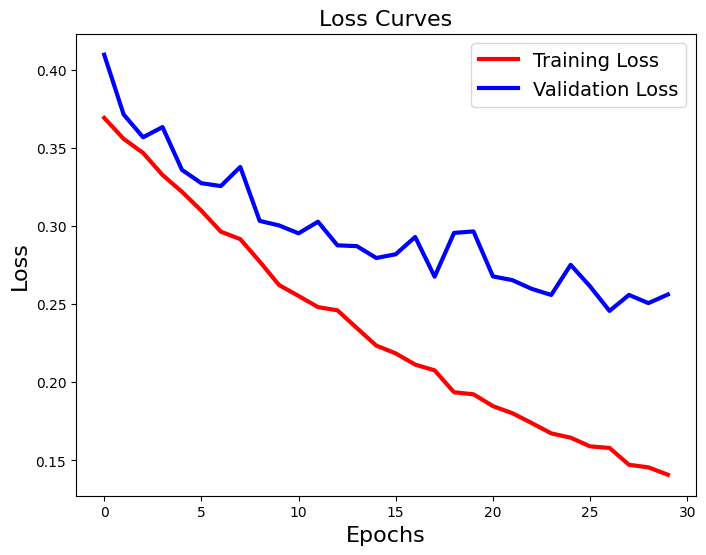

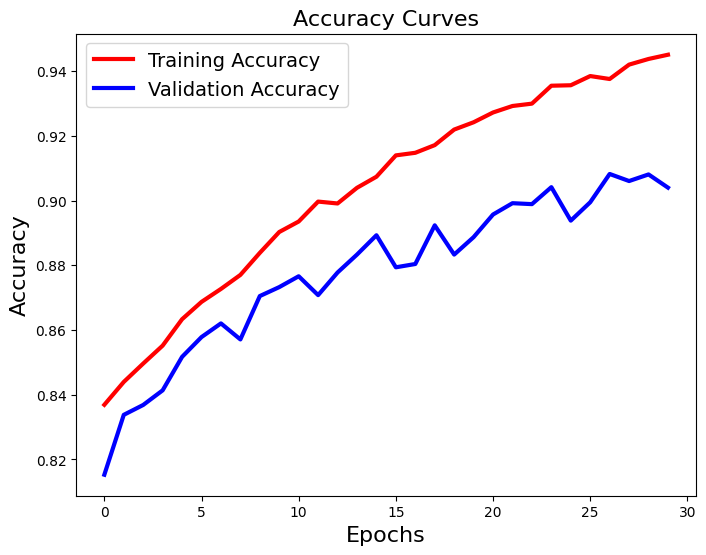

In [46]:
# Plot loss history
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

# Plot accuracy history
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

Epoch 14 might be the ideal option.

# Save the model as TFLite

In [47]:
# Save the model for further use
best_model.save('dog_cat_classifier.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

tflite_model = converter.convert()


with open('dog_cat_classifier.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# This dataset actually belongs to an old Kaggle competition, if submissions were still open, we could submit a csv with the code below:

## Prediction on the test data

In [48]:
# Apply the model to predict on test data
test_dir = "test1"
test_path = os.path.join(main_dir,test_dir)
test_data = []
for p in os.listdir(test_path):
    img_array = cv2.imread(os.path.join(test_path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    test_data.append(new_img_array)

test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data/255.0

predictions = model.predict(test_data)

391/391 [==============================] - 1s 2ms/step


In [49]:
print(predictions)

[[0.46841082]
 [0.02688147]
 [0.8809192 ]
 ...
 [0.50731206]
 [0.97929674]
 [0.9926878 ]]


## Creating a .csv file

In [50]:
# Assuming predictions is a 2D array with values between 0 and 1
predictions = model.predict(test_data)

# Convert the predictions to labels (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Get the filenames from the test directory
test_filenames = os.listdir(test_path)

# Extract the IDs from the filenames
ids = [int(filename.split('.')[0]) for filename in test_filenames]

# Create a DataFrame with "id" and "label" columns
submission_df = pd.DataFrame({'id': ids, 'label': binary_predictions.flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

391/391 [==============================] - 1s 2ms/step
